In [113]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_itl import model, sampler, cost, kernel, estimator

### Set paths and load model config / ckpt

In [114]:
# Set trained model paths
base_experiment_path = './LS_Experiments'
model_name = 'KDEF_itl_model_20201204-085606'

# get model config and ckpt
base_model_path = os.path.join(base_experiment_path, model_name, 'model/')
for fname in os.listdir(base_model_path):
    if ('config' in fname) and (fname.split('.')[-1] == 'json'):
        model_config_path = os.path.join(base_model_path, fname)
    elif ('ckpt' in fname) and (fname.split('.')[-1] == 'pt'):
        model_ckpt_path = os.path.join(base_model_path, fname)
    else:
        print(fname, 'does not exist')
print(model_config_path, model_ckpt_path)

# load ckpt and json
with open(model_config_path, 'r') as f:
    model_config = json.load(f)


./LS_Experiments/KDEF_itl_model_20201204-085606/model/itl_model_config_20201204-085606.json ./LS_Experiments/KDEF_itl_model_20201204-085606/model/itl_model_ckpt_20201204-085606.pt


### Read data

In [115]:
# ----------------------------------
# Reading input/output data
# ----------------------------------
dataset = model_config['Data']['dataset']  
theta_type = model_config['Data']['theta_type']  
inc_neutral = model_config['Data']['include_neutral']  
use_facealigner = True if model_config['Data']['input_data_version'] == 'facealigner' else False

data_path = './datasets/KDEF_Aligned/KDEF_LANDMARKS'  # set data path
if dataset == 'Rafd':
    # dirty hack only used to get Rafd speaker ids, not continuously ordered
    data_csv_path = '/home/mlpboon/Downloads/Rafd/Rafd.csv'

print('Reading data')
if use_facealigner:
    if dataset == 'KDEF':
        from datasets.datasets import kdef_landmarks_facealigner
        x_train, y_train, x_test, y_test, train_list, test_list = \
            kdef_landmarks_facealigner(data_path, inc_neutral=inc_neutral)
    elif dataset == 'Rafd':
        from datasets.datasets import rafd_landmarks_facealigner
        x_train, y_train, x_test, y_test, train_list, test_list = \
            rafd_landmarks_facealigner(data_path, data_csv_path, inc_neutral=inc_neutral)
else:
    from datasets.datasets import import_kdef_landmark_synthesis
    x_train, y_train, x_test, y_test = import_kdef_landmark_synthesis(dtype=input_data_version)

n = x_train.shape[0]
m = y_train.shape[1]
nf = y_train.shape[2]
print('data dimensions', n, m, nf)

Reading data
data dimensions 126 7 136


In [117]:
x_train_joint = y_train.reshape(-1,nf)
y_train_joint = torch.zeros(m*n, m, nf)
for i in range(m*n):
    y_train_joint[i] = y_train[i//7]

In [144]:
a = torch.randn(3,4)
a.sum(axis=1)

tensor([ 1.9434, -3.4994, -1.1163])

In [118]:
x_test_joint = y_test.reshape(-1,nf)
n_test = x_test_joint.shape[0]
y_test_joint = torch.zeros(m*n_test, m, nf)
for i in range(m*n_test):
    y_train_joint[i] = y_train[i//7]

In [119]:
# set ITL model
assert model_config['Kernels']['kernel_input_learnable'] == False
kernel_input = kernel.Gaussian(model_config['Kernels']['gamma_inp'])
kernel_output = kernel.Gaussian(model_config['Kernels']['gamma_out'])
kernel_freq = np.eye(nf) # can be added to ckpt or manually set as np.load(kernel_file)

# define emotion sampler - this can also be added to ckpt
if model_config['Data']['theta_type'] == 'aff':
    from datasets.datasets import import_affectnet_va_embedding
    affect_net_csv_path = ''  # to be set if theta_type == 'aff'
    aff_emo_dict = import_affectnet_va_embedding(affect_net_csv_path)

    sampler_ = sampler.CircularSampler(data=dataset+theta_type,
                                       inc_neutral=inc_neutral,
                                       sample_dict=aff_emo_dict)
elif theta_type == '':
    sampler_ = sampler.CircularSampler(data=dataset,
                                       inc_neutral=inc_neutral)
sampler_.m = m

itl_model = model.SpeechSynthesisKernelModel(kernel_input, kernel_output,
                                             kernel_freq=torch.from_numpy(kernel_freq).float())

### Load model and predict

In [120]:
ckpt = torch.load(model_ckpt_path)
itl_model.test_mode(x_train=x_train_joint, thetas=sampler_.sample(m), alpha=ckpt['itl_alpha'])

In [137]:
pred_test = itl_model.forward(x_test_joint, sampler_.sample(m))

In [138]:
check_output = pred_test*128
check_output[0,0].reshape(68,2)

tensor([[0.0254, 0.0527],
        [0.0269, 0.0656],
        [0.0294, 0.0779],
        [0.0317, 0.0902],
        [0.0354, 0.1019],
        [0.0418, 0.1123],
        [0.0512, 0.1208],
        [0.0622, 0.1273],
        [0.0749, 0.1292],
        [0.0877, 0.1270],
        [0.0989, 0.1202],
        [0.1082, 0.1117],
        [0.1146, 0.1011],
        [0.1179, 0.0894],
        [0.1200, 0.0771],
        [0.1220, 0.0646],
        [0.1231, 0.0517],
        [0.0326, 0.0441],
        [0.0384, 0.0378],
        [0.0473, 0.0352],
        [0.0566, 0.0350],
        [0.0656, 0.0374],
        [0.0808, 0.0376],
        [0.0897, 0.0351],
        [0.0990, 0.0351],
        [0.1078, 0.0376],
        [0.1141, 0.0438],
        [0.0730, 0.0490],
        [0.0731, 0.0580],
        [0.0733, 0.0670],
        [0.0733, 0.0762],
        [0.0639, 0.0812],
        [0.0685, 0.0830],
        [0.0737, 0.0846],
        [0.0788, 0.0829],
        [0.0836, 0.0810],
        [0.0428, 0.0517],
        [0.0482, 0.0476],
        [0.0

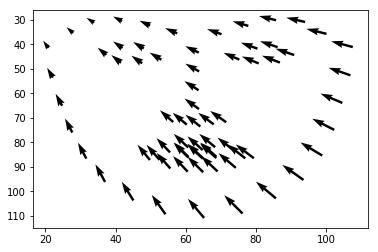

In [143]:
%matplotlib inline
plt_x = x_test[0].numpy().reshape(68, 2)
plt_xt = pred_test[1, 4].detach().numpy().reshape(68, 2)
if use_facealigner:
    plt_x = plt_x * 128
    plt_xt = plt_xt * 128
plt_uv = plt_xt - plt_x
plt.quiver(plt_x[:, 0], plt_x[:, 1], plt_uv[:, 0], plt_uv[:, 1], angles='xy')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

### Continuous generation

In [124]:
def circular_sampling(theta1, theta2, num_samples):
    angle1 = np.arctan2(theta1[1], theta1[0])
    angle2 = np.arctan2(theta2[1], theta2[0])
    angle1 = angle1 if angle1>=0 else angle1+(2*np.pi)
    angle2 = angle2 if angle2>=0 else angle2+(2*np.pi)
    
    reverse = False
    if angle1>angle2:
        start = angle2; end = angle1
        reverse = True
    else:
        start = angle1; end = angle2
        
    sampled_angles = np.linspace(start=start, stop=end, num=num_samples, endpoint=True)
    sample_coords = np.vstack((np.cos(sampled_angles), np.sin(sampled_angles))).T
    
    if reverse:
        return np.flipud(sample_coords)
    else:
        return sample_coords

def radial_sampling(theta, num_samples):
    angle = np.arctan2(theta[1], theta[0])
    sampled_radii = np.linspace(start=0, stop=1, num=num_samples, endpoint=True)
    sample_coords = np.vstack((sampled_radii*np.cos(angle), sampled_radii*np.sin(angle))).T
    return sample_coords


class EdgeMap(object):
    def __init__(self, out_res, num_parts=3):
        self.out_res = out_res
        self.num_parts = num_parts
        self.groups = [
            [np.arange(0, 17, 1), 255],
            [np.arange(17, 22, 1), 255],
            [np.arange(22, 27, 1), 255],
            [np.arange(27, 31, 1), 255],
            [np.arange(31, 36, 1), 255],
            [list(np.arange(36, 42, 1)) + [36], 255],
            [list(np.arange(42, 48, 1)) + [42], 255],
            [list(np.arange(48, 60, 1)) + [48], 255],
            [list(np.arange(60, 68, 1)) + [60], 255]
        ]

    def __call__(self, shape):
        image = np.zeros((self.out_res, self.out_res, self.num_parts), dtype=np.float32)
        for g in self.groups:
            for i in range(len(g[0]) - 1):
                start = int(shape[g[0][i]][0]), int(shape[g[0][i]][1])
                end = int(shape[g[0][i + 1]][0]), int(shape[g[0][i + 1]][1])
                cv2.line(image, start, end, g[1], 1)
        return image

In [127]:
import cv2
sampling_type = 'radial'
num_samples = 10
ckpt = torch.load(model_ckpt_path)
itl_model.test_mode(x_train=x_train_joint, thetas=sampler_.sample(m), alpha=ckpt['itl_alpha'])
if sampling_type == 'circular':
    sampled_emotions = circular_sampling(aff_emo_dict['Happy'], aff_emo_dict['Surprise'], num_samples)
elif sampling_type == 'radial':
    sampled_emotions = radial_sampling(aff_emo_dict['Happy'], num_samples)
EM = EdgeMap(out_res=128, num_parts=1)

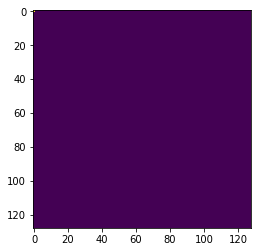

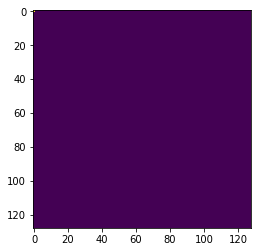

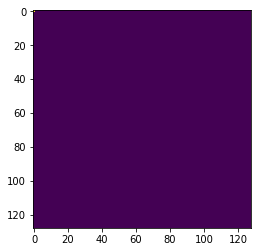

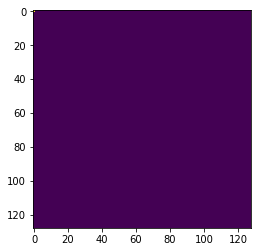

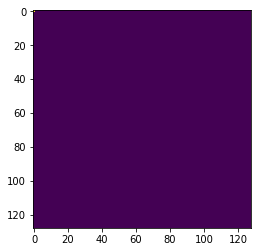

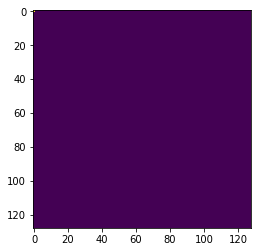

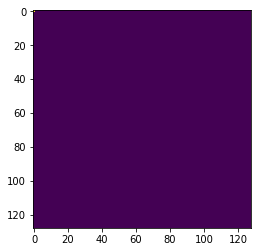

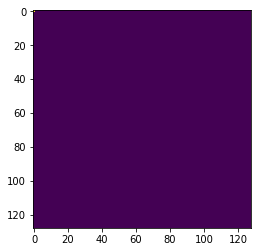

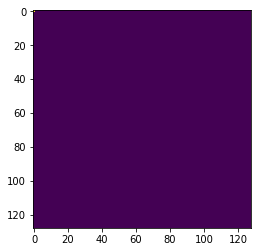

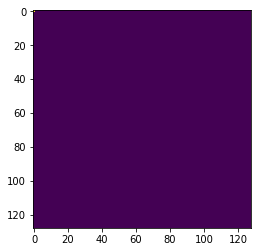

In [129]:
%matplotlib inline
for i in range(len(sampled_emotions)):
    pred_test = itl_model.forward(x_test_joint, torch.from_numpy(sampled_emotions[i][np.newaxis]).float())
    im_em = EM(pred_test[0, 0].detach().numpy().reshape(68,2)*128)
    plt.imshow(np.squeeze(im_em))
    plt.pause(0.5)

### Behaviour of the classifier

In [130]:
%matplotlib inline
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
imlist = []
for i in range(len(sampled_emotions)):
    pred_test = itl_model.forward(x_test_joint, torch.from_numpy(sampled_emotions[i][np.newaxis]).float())
    im_em = EM(pred_test[0, 0].detach().numpy().reshape(68,2)*128)
    imlist.append(transforms.ToTensor()(im_em.copy()))
    #imlist.append(transforms.ToTensor()(im_em.copy()))
#show(make_grid(imlist, nrow=10, padding=10, pad_value=1))
#save_image(imlist, 'radial_happy_to_surprise.jpg', nrow=10, padding=10, pad_value=1)

In [132]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if dataset == 'KDEF':
    num_classes = 8
    MODEL_PATH = ''
elif dataset == 'Rafd':
    num_classes = 8
    MODEL_PATH = './utils/landmark_utils/Classification/LndExperiments/Rafd_bs16_e10_20201118-055249'

# model def
def model(model_name, num_classes):
    if model_name == 'resnet-18':
        model_ft = models.resnet18(pretrained=False)
        model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft


# Get ResNet and load wts
emo_model_ft = model('resnet-18', num_classes)
emo_model_ft.load_state_dict(torch.load(MODEL_PATH, map_location=lambda storage, loc: storage))
emo_model_ft = emo_model_ft.to(device)
emo_model_ft.eval()

inputs = F.interpolate(torch.stack(imlist), size=224, mode='bilinear')
outputs = emo_model_ft(inputs/255.)
sout = nn.functional.softmax(outputs, dim=1)
sout_np = sout.detach().numpy()

FileNotFoundError: [Errno 2] No such file or directory: ''

### Generate combined continuous generation and classifier behaviour

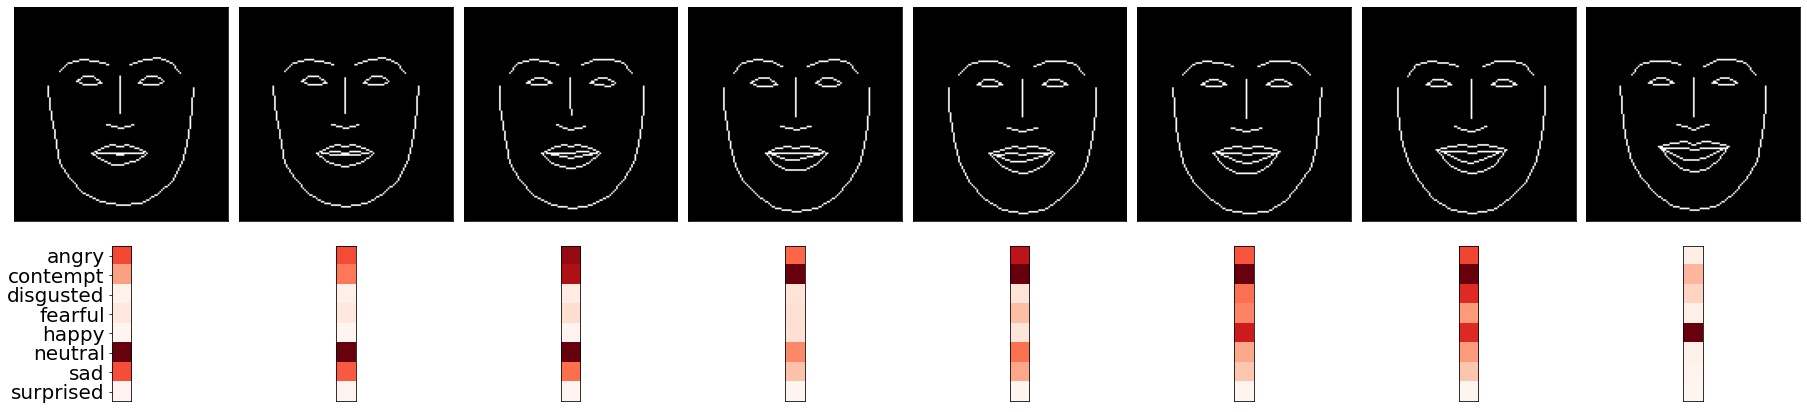

In [169]:
if dataset == 'Rafd':
    plt_emo_labels = ['angry', 'contempt', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
elif dataset == 'KDEF':
    plt_emo_labels = ['AF', 'AN', 'DI', 'HA', 'NE', 'SA', 'SU']    
rows = 2
columns = 8
fig=plt.figure(figsize=(32,8))
gs = fig.add_gridspec(3, 8)
for i in range(1, rows*columns + 1):
    if i <=(rows*columns/2):
        fig.add_subplot(gs[0:2, i-1])
        plt.imshow(np.squeeze(imlist[i].numpy()), cmap='gray')
        plt.yticks([])
        plt.xticks([])
    else:
        fig.add_subplot(gs[2:, int(i-(rows*columns/2)-1)])
        plt.imshow(sout.detach().numpy()[int(i-1-(rows*columns/2))][:,np.newaxis], cmap='Reds', interpolation='nearest')
        if i == 1+(rows*columns/2):
            plt.yticks(np.linspace(0, num_classes-1, endpoint=True, num=8), plt_emo_labels, fontsize=20)
        else:
            plt.yticks([])
        plt.xticks([])
plt.subplots_adjust(hspace = -0.1, wspace=0.05)
plt.savefig('plot_cls_cont.png',bbox_inches='tight',pad_inches=0.1)